In [1]:
from aquacrop.classes import *
from aquacrop.core import *
 
# import gym
# from gym import spaces
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
from aquacrop.lars import *
# import math

In [2]:
from aquacropgym.utils import calc_eto_faopm
from aquacropgym.envs import CropEnv, nebraska_maize_config, cordoba_cotton_config,california_tomato_config
from aquacropgym.utils import evaluate_agent,evaluate_agent_single_year
from aquacropgym.utils import calc_eto_faopm

In [3]:
#CP  Lat.(deg)= 40.40  Long.(deg)=101.73  Elev.(m)=1072.
gendf1000=calc_eto_faopm('data/CPWG_1000.dat',1995,40.4,1072,True,["simyear","jday","minTemp","maxTemp","precip","rad"])
gendf=calc_eto_faopm('data/CPWG.dat',1995,40.4,1072,True,["simyear","jday","minTemp","maxTemp","precip","rad"])
# gendf=calc_eto_faopm('data/CDWG.dat',1995,37.31,110,True,["simyear","jday","minTemp","maxTemp","precip","rad"])
# gendf= calc_eto_faopm('data/CLWG.dat',1995,37.49,14.0,True,["simyear","jday","minTemp","maxTemp","precip","rad"])


In [4]:
gendf.head()

,simyear,MinTemp,MaxTemp,Precipitation,ReferenceET,Date
0,1,-2.1,-1.2,0.0,0.840868,1995-01-01
1,1,-11.0,18.9,0.0,3.425219,1995-01-02
2,1,-9.0,8.2,0.0,1.950843,1995-01-03
3,1,-5.8,16.5,0.0,2.889402,1995-01-04
4,1,-8.4,-0.8,0.0,1.078832,1995-01-05


In [44]:
envconfig=nebraska_maize_config.copy()
envconfig['gendf']=gendf1000
envconfig['year2']=1000
envconfig['action_set']='smt4'
envconfig['normalize_obs']=True
envconfig['include_rain']=True
envconfig['observation_set']='default'
# envconfig['action_set']='depth_discreet'
envconfig['days_to_irr']=2

# envconfig['crop']=CropClass('Wheat',PlantingDate='05/01',)
# envconfig['planting_date']='05/01'
# envconfig['fixed_cost']=0
# envconfig['crop_price']=312

In [6]:
env=CropEnv(envconfig)
# env.get_mean_std(1000)

In [7]:
env.mean

array([1.5068182e+01, 6.7727275e+00, 4.4094244e-01, 6.8477272e+01,
       1.2823775e+02, 6.5737528e-01, 1.2552679e+03, 2.2174017e+00,
       5.9947405e+00, 1.6800790e+02, 4.0232184e+02, 2.2348366e+00,
       6.0216384e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00], dtype=float32)

In [8]:
env.std

array([8.8430672e+00, 1.2588633e+00, 2.1731496e-01, 3.8057072e+01,
       8.1543999e+01, 3.7534222e-01, 1.0305146e+03, 2.6845067e+00,
       9.4314069e-01, 1.0874526e+02, 2.4056461e+02, 6.7858462e+00,
       1.6485872e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00,
       1.0000000e+00], dtype=float32)

In [9]:
import ray

In [45]:
ray.shutdown()

In [46]:
ray.init(num_cpus=8,num_gpus=1)

{'node_ip_address': '192.168.1.23',
 'raylet_ip_address': '192.168.1.23',
 'redis_address': None,
 'object_store_address': '/tmp/ray/session_2022-04-12_14-19-37_166590_4974/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2022-04-12_14-19-37_166590_4974/sockets/raylet',
 'webui_url': None,
 'session_dir': '/tmp/ray/session_2022-04-12_14-19-37_166590_4974',
 'metrics_export_port': 59123,
 'gcs_address': '192.168.1.23:55693',
 'address': '192.168.1.23:55693',
 'node_id': '81a8108fc3c3f2073c9e930fadca2f17f82fb96dc150ca8d2f04936f'}

In [47]:
from ray.rllib.agents.ppo import ppo

config = ppo.DEFAULT_CONFIG.copy()

config['num_workers'] = 8
config['num_gpus'] = 1
config['observation_filter'] = 'NoFilter'

# config['num_envs_per_worker'] = 8
# config['num_sgd_iter'] = 30
# config['lr'] = 3e-5
# config['sgd_minibatch_size'] = 1028
# config['batch_mode'] = 'complete_episodes'
config['rollout_fragment_length'] = 160
config['train_batch_size'] = 160*8*20
config['model']['fcnet_hiddens'] = [256]*4
config['num_cpus_per_worker'] = 0  # This avoids running out of resources in the notebook environment when this cell is re-executed
config['framework'] = 'torch'
config['gamma'] = 1.
config['env_config']=envconfig
config['model']['use_lstm'] = False
# config['model']['lstm_cell_size'] = 64
# config['model']['max_seq_len'] = 40
config['model']['vf_share_layers'] = False


In [ ]:
from ray.rllib.agents.ars import ars

config = ars.DEFAULT_CONFIG.copy()

config['num_workers'] = 8
config['observation_filter'] = 'NoFilter'
config['num_rollouts'] = 100
config['rollouts_used'] = 100
config['evaluation_config'] = {}
# config['num_sgd_iter'] = 30
# config['lr'] = 3e-5
# config['sgd_minibatch_size'] = 1028
# config['batch_mode'] = 'complete_episodes'
# config['rollout_fragment_length'] = 150
# config['train_batch_size'] = 150*16
config['model']['fcnet_hiddens'] = []
config['num_cpus_per_worker'] = 0  # This avoids running out of resources in the notebook environment when this cell is re-executed
config['framework'] = 'torch'
config['gamma'] = 0.99999999
config['env_config']=envconfig
# config['model']['use_lstm'] = True
# config['model']['lstm_cell_size'] = 64
# config['model']['max_seq_len'] = 40

In [34]:
from ray.rllib.agents.dqn.apex import ApexTrainer,APEX_DEFAULT_CONFIG

config=APEX_DEFAULT_CONFIG.copy()
config['gamma'] = 1.
config['framework'] = 'torch'
config['num_workers'] = 8
config['num_gpus'] = 0
config['hiddens'] = [256]*2
config['buffer_size'] = 400_000
config['num_cpus_per_worker'] = 0  # This avoids running out of resources in the notebook environment when this cell is re-executed
config['env_config']=envconfig


In [ ]:
from ray.rllib.agents.impala import impala

config = impala.DEFAULT_CONFIG.copy()
config['observation_filter'] = 'NoFilter'

config['num_workers'] = 8
config['num_gpus'] = 0
# config['num_envs_per_worker'] = 8
# config['num_sgd_iter'] = 30
# config['lr'] = 3e-5
# config['sgd_minibatch_size'] = 1028
# config['batch_mode'] = 'complete_episodes'
config['rollout_fragment_length'] = 200
config['train_batch_size'] = 200*8
config['model']['fcnet_hiddens'] = [256]*2
config['num_cpus_per_worker'] = 0  # This avoids running out of resources in the notebook environment when this cell is re-executed
config['framework'] = 'torch'
config['gamma'] = 0.9999999999
config['env_config']=envconfig
config['model']['use_lstm'] = False
# config['model']['lstm_cell_size'] = 64
config['model']['max_seq_len'] = 40
# config['model']['seq_len'] = 40


In [25]:
from ray.rllib.agents.sac import sac

config = sac.DEFAULT_CONFIG.copy()
config['observation_filter'] = 'NoFilter'

config['num_workers'] = 8
config['num_gpus'] = 0
# config['num_envs_per_worker'] = 8
# config['num_sgd_iter'] = 30
config['horizon'] = 1000
config['target_network_update_freq'] = 1
# config['batch_mode'] = 'complete_episodes'
config['timesteps_per_iteration'] = 1000
config['rollout_fragment_length'] = 1
# config['model']['fcnet_hiddens'] = [256]*2
config['num_cpus_per_worker'] = 1  # This avoids running out of resources in the notebook environment when this cell is re-executed
config['framework'] = 'torch'
config['gamma'] = 0.9999999999
config['env_config']=envconfig
# config['model']['use_lstm'] = False
config['prioritized_replay'] = True
# config['model']['max_seq_len'] = 40
# config['model']['seq_len'] = 40
# config['model']['initial_alpha'] = 0.



In [ ]:
from ray.rllib.agents.es import ESTrainer,es

config = es.DEFAULT_CONFIG.copy()

config['env'] = CropEnv
config['num_workers'] = 16
config['num_gpus'] = 0
# config['num_envs_per_worker'] = 8
config['observation_filter'] = "NoFilter"
# config['lr'] = 3e-5
# config['sgd_minibatch_size'] = 1028
# config['batch_mode'] = 'complete_episodes'
# config['rollout_fragment_length'] = 150*16
# config['train_batch_size'] = 150*16*8
config['model']['fcnet_hiddens'] = [256]*2
config['num_cpus_per_worker'] = 0  # This avoids running out of resources in the notebook environment when this cell is re-executed
config['framework'] = 'torch'
config['gamma'] = 0.99999999
config['env_config']=envconfig
# config['model']['use_lstm'] = True
# config['model']['lstm_cell_size'] = 64
# config['model']['max_seq_len'] = 40
config['model']['vf_share_layers'] = False

# agent = ESTrainer(config)
# agent.policy.set_weights(es_weights)
# # agent.set_weights(bcweights,)
# checkpoint_path = agent.save()
# print(checkpoint_path)

In [48]:
agent = ppo.PPOTrainer(config, CropEnv)
# agent = impala.ImpalaTrainer(config, CropEnv)
# agent = ApexTrainer(config, CropEnv)

# agent = sac.SACTrainer(config, CropEnv)
# agent = ESTrainer(config)


2022-04-12 14:19:55,269	WARNING util.py:55 -- Install gputil for GPU system monitoring.


In [49]:
from aquacropgym.utils import evaluate_agent
import copy

In [ ]:
# test_env_config=copy.deepcopy(envconfig)
# test_env_config['evaluation_run']=True
# config['env_config']['days_to_irr']=1

# train_rew, test_rew = evaluate_agent(agent,CropEnv,test_env_config)

# print(f'Train:{round(train_rew,3)}')
# print(f'Test:{round(test_rew,3)}')

In [50]:
# testconfig=copy.deepcopy(config)
# # testconfig['env_config']['days_to_irr']=3

# agent = ppo.PPOTrainer(testconfig, CropEnv)
# agent = ppo.PPOTrainer(config, CropEnv)

# checkpoint_path="/home/mbyx3tk2/ray_results/PPO_CropEnv_2022-02-18_14-57-34s8iz8dhe/checkpoint_000270/checkpoint-270"

# # checkpoint_path
agent.restore(checkpoint_path)

#/home/mbyx3tk2/ray_results/PPOTrainer_CropEnv_2022-04-12_08-47-29l5b4dt2n/checkpoint_000090/checkpoint-90


2022-04-12 14:19:55,985	INFO trainable.py:495 -- Restored on 192.168.1.23 from checkpoint: /home/mbyx3tk2/ray_results/PPOTrainer_CropEnv_2022-04-12_14-08-21cnrvuxc4/checkpoint_000095/checkpoint-95
2022-04-12 14:19:55,985	INFO trainable.py:503 -- Current state after restoring: {'_iteration': 95, '_timesteps_total': 1472000, '_time_total': 3509.791106939316, '_episodes_total': 79760}


eval
Train:508.408
Test:510.211
eval
Train:509.174
Test:513.865
(RolloutWorker pid=33328) 441 100 -861.3365539554151
(RolloutWorker pid=33332) 49 100 -855.1094752235631
(RolloutWorker pid=33335) 699 100 -854.2452942257377
(RolloutWorker pid=33329) 904 100 -851.810062360001
(RolloutWorker pid=33331) 772 100 -859.7161697456345
(RolloutWorker pid=33334) 855 100 -856.7461348100506
(RolloutWorker pid=33333) 236 100 -857.7337393283099
(RolloutWorker pid=33330) 580 100 -854.548707743973
eval
Train:509.288
Test:513.007
eval
Train:511.225
Test:516.678
(RolloutWorker pid=33328) 830 200 -736.2096784959198
(RolloutWorker pid=33332) 506 200 -720.4509235591763
(RolloutWorker pid=33335) 584 200 -717.3468149053392
(RolloutWorker pid=33329) 289 200 -720.4546528924869
(RolloutWorker pid=33331) 99 200 -734.1545627992384
(RolloutWorker pid=33334) 983 200 -732.527350351355
(RolloutWorker pid=33333) 280 200 -727.8700442952379
(RolloutWorker pid=33330) 710 200 -725.8883569182937
/home/mbyx3tk2/ray_results/PP

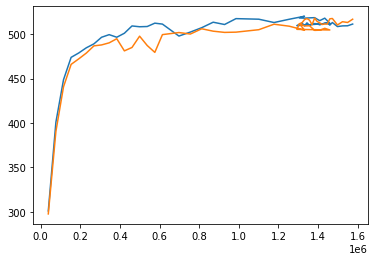

eval
Train:508.608
Test:511.8
eval
Train:510.602
Test:513.176
(RolloutWorker pid=33332) 657 300 -600.8825228740184
(RolloutWorker pid=33335) 760 300 -603.999208689977
(RolloutWorker pid=33329) 436 300 -601.9442519202054
(RolloutWorker pid=33334) 277 300 -609.4123539125361
(RolloutWorker pid=33333) 875 300 -607.0260711860659
(RolloutWorker pid=33330) 710 300 -606.9993478491137
(RolloutWorker pid=33328) 495 300 -621.7809641908208
(RolloutWorker pid=33331) 977 300 -616.4110781416089
eval
Train:511.233
Test:513.006
eval
Train:509.92
Test:510.99
(RolloutWorker pid=33328) 482 400 -523.2381658864273
(RolloutWorker pid=33332) 646 400 -487.81141436345445
(RolloutWorker pid=33335) 870 400 -493.56781484650344
(RolloutWorker pid=33329) 610 400 -493.68514858922356
(RolloutWorker pid=33331) 534 400 -501.7891977342487
(RolloutWorker pid=33334) 812 400 -494.38856988555006
(RolloutWorker pid=33333) 279 400 -498.5823482754225
(RolloutWorker pid=33330) 568 400 -503.3748700834903
eval
Train:513.091
Test:5

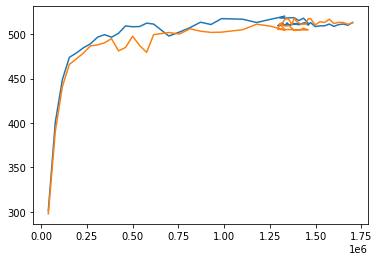

eval
Train:507.835
Test:516.385
(RolloutWorker pid=33328) 234 500 -436.59241820386893
(RolloutWorker pid=33332) 654 500 -390.8526938621884
(RolloutWorker pid=33335) 172 500 -395.5150465622849
(RolloutWorker pid=33329) 328 500 -394.0001295965048
(RolloutWorker pid=33331) 410 500 -403.43916906199354
(RolloutWorker pid=33334) 939 500 -403.45261092019547
(RolloutWorker pid=33333) 913 500 -402.39877398632336
(RolloutWorker pid=33330) 505 500 -397.10628134474473
eval
Train:508.575
Test:519.962
eval
Train:511.135
Test:514.343
(RolloutWorker pid=33328) 240 600 -343.20350989951
(RolloutWorker pid=33329) 761 600 -303.12918745799095
(RolloutWorker pid=33331) 995 600 -309.7181649261692
(RolloutWorker pid=33334) 692 600 -315.0187271651472
(RolloutWorker pid=33333) 407 600 -307.1197046968868
(RolloutWorker pid=33330) 207 600 -315.5500161186792
(RolloutWorker pid=33332) 305 600 -308.5065517306048
(RolloutWorker pid=33335) 648 600 -316.9562927774491
eval
Train:508.911
Test:510.311
eval
Train:508.628
T

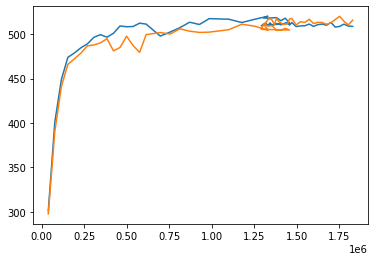

eval
Train:511.854
Test:513.836
eval
Train:509.077
Test:512.006
(RolloutWorker pid=33328) 30 800 -185.2120850783093
(RolloutWorker pid=33332) 489 800 -168.9432081257755
(RolloutWorker pid=33335) 743 800 -177.13346670387537
(RolloutWorker pid=33329) 101 800 -171.02063119937714
(RolloutWorker pid=33331) 71 800 -150.16082745225307
(RolloutWorker pid=33334) 733 800 -164.4562423210219
(RolloutWorker pid=33333) 899 800 -145.87821634218741
(RolloutWorker pid=33330) 694 800 -177.6253836575825


KeyboardInterrupt: 

In [51]:
# proftrain=[]
# proftest=[]
# timesteps=[]

for i in range(1,500001):
    result = agent.train()

    ts = result['timesteps_total']

    #print(pretty_print(result))

    if i%5==0:
        checkpoint_path = agent.save()
        print(checkpoint_path)
        # trained_config = config.copy()
        # test_agent =ppo PPOTrainer(trained_config, CropEnv)
        # test_agent.restore(checkpoint_path)
        result_df = pd.DataFrame([timesteps,proftrain,proftest]).T
        result_df.to_csv('learn_outputs/neb_corn_ppo_day10_smt4_default_wg1000.csv')
        plt.plot(timesteps,proftrain)
        plt.plot(timesteps,proftest)
        plt.show()
        if timesteps[-1]>=40_000_000:
            break

    if i%1==0:

        print('eval')

        test_env_config=copy.deepcopy(envconfig)
        test_env_config['evaluation_run']=True
        test_env_config['gendf']=gendf
        test_env_config['year2']=70
        train_rew, test_rew = evaluate_agent(agent,CropEnv,test_env_config)
        
        proftrain.append(train_rew)
        proftest.append(test_rew)
        timesteps.append(ts)

        print(f'Train:{round(train_rew,3)}')
        print(f'Test:{round(test_rew,3)}')

    if i==300:
        break

In [ ]:
# soy 12*37 = 444
# wheat = 312
# tomato = 82
# corn = 180
# soghum = 180

In [ ]:

# import ray
# from ray.rllib.agents.ppo import ppo

# gendf=calc_eto_faopm('data/CPWG.dat',1995,40.4,1072,True,["simyear","jday","minTemp","maxTemp","precip","rad"])

# envconfig=nebraska_maize_config.copy()
# envconfig['gendf']=gendf
# envconfig['action_set']='smt4'
# envconfig['observation_set']='forecast'
# envconfig['normalize_obs']=False
# envconfig['days_to_irr']=1

# envconfig['crop']=CropClass('Maize',PlantingDate='05/01',)
# # envconfig['planting_date']='05/01'
# # envconfig['fixed_cost']=0
# # envconfig['crop_price']=312
# ray.shutdown()
# ray.init(num_cpus=8,num_gpus=0)

# config = ppo.DEFAULT_CONFIG.copy()

# config['num_workers'] = 8
# config['num_gpus'] = 0
# config['observation_filter'] = 'MeanStdFilter'

# # config['num_envs_per_worker'] = 8
# # config['num_sgd_iter'] = 30
# # config['lr'] = 3e-5
# # config['sgd_minibatch_size'] = 1028
# config['batch_mode'] = 'complete_episodes'
# config['rollout_fragment_length'] = 150
# config['train_batch_size'] = 150*8
# config['model']['fcnet_hiddens'] = [256]*2
# config['num_cpus_per_worker'] = 0  # This avoids running out of resources in the notebook environment when this cell is re-executed
# config['framework'] = 'torch'
# config['gamma'] = 0.99999999
# config['env_config']=envconfig
# config['model']['use_lstm'] = True
# config['model']['lstm_use_prev_action'] =False
# # config['model']['max_seq_len'] = 40
# config['model']['vf_share_layers'] = False

# agent = ppo.PPOTrainer(config, CropEnv)

# proftrain=[]
# proftest=[]
# timesteps=[]

for i in range(1,500001):
    result = agent.train()

    ts = result['timesteps_total']

    #print(pretty_print(result))

    if i%10==0:
        checkpoint_path = agent.save()
        print(checkpoint_path)
        # trained_config = config.copy()
        # test_agent =ppo PPOTrainer(trained_config, CropEnv)
        # test_agent.restore(checkpoint_path)
        result_df = pd.DataFrame([timesteps,proftrain,proftest]).T
        result_df.to_csv('neb_corn_ppo_day3_smt4_forecast.csv')
        plt.plot(timesteps,proftrain)
        plt.plot(timesteps,proftest)
        plt.show()
        if timesteps[-1]>=40_000_000:
            break

    if i%3==0:

        test_env_config=copy.deepcopy(envconfig)
        test_env_config['evaluation_run']=True
        train_rew, test_rew = evaluate_agent(agent,CropEnv,test_env_config)
        
        proftrain.append(train_rew)
        proftest.append(test_rew)
        timesteps.append(ts)

        print(f'Train:{round(train_rew,3)}')
        print(f'Test:{round(test_rew,3)}')

    if i==600:
        break


In [ ]:
gendf=calc_eto_faopm('data/CPWG.dat',1995,40.4,1072,True,["simyear","jday","minTemp","maxTemp","precip","rad"])

envconfig=nebraska_maize_config.copy()
envconfig['gendf']=gendf
envconfig['action_set']='smt4'
# envconfig['observation_set']='forecast'
envconfig['include_rain']=False
envconfig['days_to_irr']=3

envconfig['crop']=CropClass('Maize',PlantingDate='05/01',)
# envconfig['planting_date']='05/01'
# envconfig['fixed_cost']=0
# envconfig['crop_price']=312
ray.shutdown()
ray.init(num_cpus=8,num_gpus=0)


from ray.rllib.agents.ppo import ppo

config = ppo.DEFAULT_CONFIG.copy()

config['num_workers'] = 8
config['num_gpus'] = 0
config['observation_filter'] = 'MeanStdFilter'

# config['num_envs_per_worker'] = 8
# config['num_sgd_iter'] = 30
# config['lr'] = 3e-5
# config['sgd_minibatch_size'] = 1028
config['batch_mode'] = 'complete_episodes'
config['rollout_fragment_length'] = 150
config['train_batch_size'] = 150*8
config['model']['fcnet_hiddens'] = [256]*2
config['num_cpus_per_worker'] = 0  # This avoids running out of resources in the notebook environment when this cell is re-executed
config['framework'] = 'torch'
config['gamma'] = 0.99999999
config['env_config']=envconfig
# config['model']['use_lstm'] = True
# config['model']['lstm_cell_size'] = 64
# config['model']['max_seq_len'] = 40
config['model']['vf_share_layers'] = False

agent = ppo.PPOTrainer(config, CropEnv)

proftrain=[]
proftest=[]
timesteps=[]

for i in range(1,500001):
    result = agent.train()

    ts = result['timesteps_total']

    #print(pretty_print(result))

    if i%10==0:
        checkpoint_path = agent.save()
        print(checkpoint_path)
        # trained_config = config.copy()
        # test_agent =ppo PPOTrainer(trained_config, CropEnv)
        # test_agent.restore(checkpoint_path)
        result_df = pd.DataFrame([timesteps,proftrain,proftest]).T
        result_df.to_csv('neb_corn_ppo_day3_smt4_norain.csv')
        plt.plot(timesteps,proftrain)
        plt.plot(timesteps,proftest)
        plt.show()
        if timesteps[-1]>=40_000_000:
            break

    if i%3==0:

        test_env_config=copy.deepcopy(envconfig)
        test_env_config['evaluation_run']=True
        train_rew, test_rew = evaluate_agent(agent,CropEnv,test_env_config)
        
        proftrain.append(train_rew)
        proftest.append(test_rew)
        timesteps.append(ts)

        print(f'Train:{round(train_rew,3)}')
        print(f'Test:{round(test_rew,3)}')

    if i==600:
        break


In [ ]:
# from ray.rllib.agents.impala import ImpalaTrainer, DEFAULT_CONFIG
# from ray.rllib.agents.sac import SACTrainer, DEFAULT_CONFIG
# from ray.rllib.agents.ppo import PPOTrainer, DEFAULT_CONFIG
# from ray.rllib.agents.dqn.apex import ApexTrainer, APEX_DEFAULT_CONFIG


In [ ]:
# config=DEFAULT_CONFIG.copy()
# config['gamma'] = 0.99999
# config['framework'] = 'torch'
# config['num_workers'] = 8
# config['num_gpus'] = 0
# config['model']['fcnet_hiddens'] = [128]*4
# config['rollout_fragment_length'] = 160
# config['train_batch_size'] = 4000
# config['num_cpus_per_worker'] = 0  # This avoids running out of resources in the notebook environment when this cell is re-executed



In [ ]:
# config = DEFAULT_CONFIG.copy()
# config['num_workers'] = 16
# config['num_gpus'] = 1
# # config['num_envs_per_worker'] = 8
# # config['num_sgd_iter'] = 30
# # config['lr'] = 3e-5
# # config['sgd_minibatch_size'] = 1028
# # config['train_batch_size'] = 1028
# # config['timesteps_per_iteration'] = 4000
# # config['Q_model']['fcnet_hiddens'] = [128]*4
# # config['policy_model']['fcnet_hiddens'] = [128]*4
# config['num_cpus_per_worker'] = 0  # This avoids running out of resources in the notebook environment when this cell is re-executed
# config['framework'] = 'torch'
# config['gamma'] = 0.99999
# # config['initial_alpha'] = 0.2
# config['optimization']['actor_learning_rate'] = 1e-2
# config['optimization']['critic_learning_rate'] = 1e-2
# config['optimization']['entropy_learning_rate'] = 1e-2

# # config['model']['use_lstm'] = True
# # config['model']['lstm_cell_size'] = 64
# # config['model']['max_seq_len'] = 40

In [ ]:
# config = DEFAULT_CONFIG.copy()
# config['num_workers'] = 8
# config['num_gpus'] = 0
# # config['num_envs_per_worker'] = 8
# # config['num_sgd_iter'] = 30
# # config['lr'] = 3e-5
# # config['sgd_minibatch_size'] = 1028
# config['train_batch_size'] = 4000
# config['model']['fcnet_hiddens'] = [128]*4
# config['num_cpus_per_worker'] = 0  # This avoids running out of resources in the notebook environment when this cell is re-executed
# config['framework'] = 'torch'
# config['gamma'] = 0.99999
# config['env_config']={"evaluation_run":False}
# config['model']['use_lstm'] = True
# config['model']['lstm_cell_size'] = 64
# config['model']['max_seq_len'] = 40

In [ ]:
# config = DEFAULT_CONFIG.copy()
# config['num_workers'] = 8
# # config['num_envs_per_worker'] = 8
# # config['num_sgd_iter'] = 30
# config['lr'] = 3e-5
# # config['sgd_minibatch_size'] = 1028
# config['train_batch_size'] = 1028
# config['Q_model']['fcnet_hiddens'] = [128]*4
# config['policy_model']['fcnet_hiddens'] = [128]*4
# config['num_cpus_per_worker'] = 0  # This avoids running out of resources in the notebook environment when this cell is re-executed
# config['framework'] = 'torch'
# config['gamma'] = 0.99999
# config['target_network_update_freq'] = 1

# # config['model']['use_lstm'] = True
# # config['model']['lstm_cell_size'] = 64
# # config['model']['max_seq_len'] = 17

In [ ]:
# agent = PPOTrainer(config, CropEnv)
# agent = SACTrainer(config, CropEnv)
# agent = ImpalaTrainer(config, CropEnv)
# agent = ApexTrainer(config, CropEnv)


# checkpoint_path
# agent.restore(checkpoint_path)